<a href="https://colab.research.google.com/github/NicoRota-0/BIS-project/blob/main/BIS_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install pm4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.1 MB/s 
  Created wheel for pyvis: filename=pyvis-0.2.1-py3-none-any.whl size=23688 sha256=0fa5f1bc37a6640ea7bbb8c6817437e0e553f8d0707ec28d3eaab39ff4d7cf9c
  Stored in directory: /root/.cache/pip/wheels/2a/8f/04/6340d46afc74f59cc857a594ca1a2a14a1f4cbd4fd6c2e9306
  Created wheel for stringdist: filename=StringDist-1.0.9-cp37-cp37m-linux_x86_64.whl size=23598 sha256=8228b9b9f02d225226c594dde7fbc31048bfc96578f259ecb5e8fa6c2ee4a6b4
  Stored in directory: /root/.cache/pip/wheels/d7/9c/d4/63bc3d8931de0980b9e4a724dea290bb40b8b1b2bd6227c8da
Successfully built pyvis stringdist


In [ ]:
import pandas as pd
import numpy as np
import pm4py
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy.stats import pareto
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.filtering.log.timestamp import timestamp_filter
from pm4py.algo.filtering.log.start_activities import start_activities_filter
from pm4py.algo.filtering.log.attributes import attributes_filter
from pm4py.statistics.traces.generic.log import case_statistics
from pm4py.algo.discovery.temporal_profile import algorithm as temporal_profile_discovery

# process mining 
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.discovery.batches import algorithm 

# visual
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.objects.conversion.process_tree import converter as pt_converter

# eval
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

In [ ]:
PATH = 'drive/MyDrive/BIS_files/'

In [ ]:
def load_filter_log(file_name, date1 = "2018-01-01 00:00:00", date2 = "2019-12-31 23:59:59"):
  """This function loads and filter a log from a xes file,
  the filter eliminates all the cases with events outside the interval
  defined by the two timestamp in input.
  """
  tmp_log = xes_importer.apply(PATH + file_name + '.xes')

  activities_all = attributes_filter.get_attribute_values(tmp_log, "id")
  list_activities_id_all = len(list(activities_all))

  # filtering all the events happened/started in 2017
  filtered_log = timestamp_filter.filter_traces_contained(tmp_log, date1, date2)

  # filtering events < 2 and > 100
  filtered_log = pm4py.filter_case_size(log, 2, 100)

  # filtering events < 24h and > 1000 days
  filtered_log = pm4py.filter_case_performance(log, 86400, 1000*86400)

  activities_all = attributes_filter.get_attribute_values(filtered_log, "id")
  
  list_activities_id_filt = len(list(activities_all))

  print(file_name + ' Data Before filtering:', str(list_activities_id_all), 'Events;', str(len(tmp_log)), 'Cases.')
  print(file_name + ' Data After filtering:', str(list_activities_id_filt), 'Events;', str(len(filtered_log)), 'Cases.')
  
  return filtered_log

In [ ]:
def compute_duration_statistics(log):
  all_case_durations = pm4py.get_all_case_durations(log)
  mean = np.mean(all_case_durations)
  std = np.std(all_case_durations)
  median = np.median(all_case_durations)
  min = np.min(all_case_durations)
  max = np.max(all_case_durations)
  print("Mean:", mean/86400.0, "Standard deviation:", std/86400.0, 
        "Median:", median/86400.0, "Min:", min/86400.0, "Max:", max/86400.0)
  """
  data_log = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)
  profile = data_log.groupby('case:concept:name').agg(
  Activity = ('concept:name', 'count'),\
  Activity_list = ('concept:name', lambda x: ','.join(x) ),\
  Rosource = ('org:resource', 'nunique'),\
  Duration = ('time:timestamp', lambda x: x.max()- x.min()),\
  )
  mean_duration = profile[(profile['Duration'] > '0:0:0')].agg('max')
  """
  return all_case_durations

def duration_boxplot(all_case_durations, log_name):
  lis = np.divide(all_case_durations, 86400.0)
  fig = plt.figure(figsize = (15, 5))
  plt.title('Box-Plot ' + log_name)
  red_square = dict(markerfacecolor='r', marker='s')
  plt.boxplot(lis, flierprops=red_square, vert=False, autorange = True)

def variant_analysis(log, log_name):
  # Count the cases per variant 
  variants_count = case_statistics.get_variant_statistics(log)
  variants_count = sorted(variants_count, key=lambda x: x['count'], reverse=True)

  print('Number of variants:', len(variants_count))
  variants_df = pd.DataFrame.from_records(variants_count)

  # Prepare the dimensions to plot
  # Put variants and counts into lists of prefered length
  variant = variants_df[0:100].index
  frequency = variants_df[0:100]['count']

  # return a list of log values from a list 
  frequency_log = [math.log(i, 2) for i in frequency] 

  # Plot the histogram of the frequencies
  fig = plt.figure(figsize = (15, 5))

  # creating the bar plot
  plt.bar(variant, frequency, color ='orange',
          width = 0.4)
  plt.xlabel("variants sorted by frequency")
  plt.ylabel("frequency")
  plt.title("bar chart of variants frequency for " + log_name)
  return variants_df

def variant_cdf_pdf(variants_df):
  data= variants_df[1:100]['count']
  # getting data of the histogram
  count, bins_count = np.histogram(data, bins=100)

  # finding the PDF of the histogram using count values
  pdf = count / sum(count)
    
  # using numpy np.cumsum to calculate the CDF
  # We can also find using the PDF values by looping and adding
  cdf = np.cumsum(pdf)
    
  # plotting PDF (probability density function) and CDF (cumulative densitive function)
  plt.plot(bins_count[1:], pdf, color="red", label="PDF")
  plt.plot(bins_count[1:], cdf, label="CDF")
  plt.legend()

**Loading and Filtering Events that started in 2017**

In [ ]:
domesticDeclarations = load_filter_log('DomesticDeclarations')
internationalDeclarations = load_filter_log('InternationalDeclarations')
permitLog = load_filter_log('PermitLog')
prepaidTravelCost = load_filter_log('PrepaidTravelCost')
requestForPayment = load_filter_log('RequestForPayment')
logs = {"DomesticDeclarations": domesticDeclarations, "InternationalDeclarations": internationalDeclarations, 
       "PermitLog": permitLog, "PrepaidTravelCost": prepaidTravelCost, "RequestForPayment": requestForPayment}

parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

DomesticDeclarations Data Before filtering: 56437 Events; 10500 Cases.
DomesticDeclarations Data After filtering: 46375 Events; 8260 Cases.


parsing log, completed traces ::   0%|          | 0/6449 [00:00<?, ?it/s]

InternationalDeclarations Data Before filtering: 69073 Events; 6449 Cases.
InternationalDeclarations Data After filtering: 55576 Events; 4951 Cases.


parsing log, completed traces ::   0%|          | 0/7065 [00:00<?, ?it/s]

PermitLog Data Before filtering: 86581 Events; 7065 Cases.
PermitLog Data After filtering: 71063 Events; 5596 Cases.


parsing log, completed traces ::   0%|          | 0/2099 [00:00<?, ?it/s]

PrepaidTravelCost Data Before filtering: 16205 Events; 2099 Cases.
PrepaidTravelCost Data After filtering: 14024 Events; 1776 Cases.


parsing log, completed traces ::   0%|          | 0/6886 [00:00<?, ?it/s]

RequestForPayment Data Before filtering: 36796 Events; 6886 Cases.
RequestForPayment Data After filtering: 31820 Events; 5778 Cases.


Duration statistics for  DomesticDeclarations log
Mean: 11.560635300365437 Standard deviation: 15.936806753273334 Median: 7.872517361111111 Min: 0.0 Max: 469.23631944444446
Duration statistics for  InternationalDeclarations log
Mean: 76.22178016085415 Standard deviation: 56.68729848450383 Median: 63.817696759259256 Min: 6.729988425925926 Max: 463.05258101851854
Duration statistics for  PermitLog log
Mean: 83.83653124214055 Standard deviation: 57.392720472058755 Median: 71.09936342592593 Min: 0.5253703703703704 Max: 463.05258101851854
Duration statistics for  PrepaidTravelCost log
Mean: 36.60464680174967 Standard deviation: 39.50157979764692 Median: 24.057471064814816 Min: 0.0 Max: 324.97599537037036
Duration statistics for  RequestForPayment log
Mean: 12.354546698123789 Standard deviation: 16.706341005502974 Median: 8.913640046296296 Min: 0.0 Max: 405.99306712962965


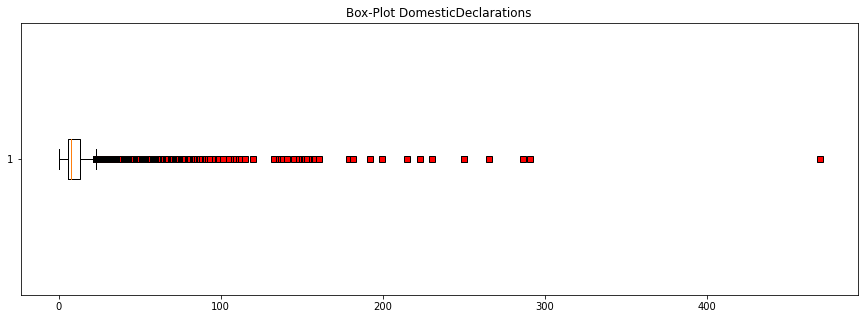

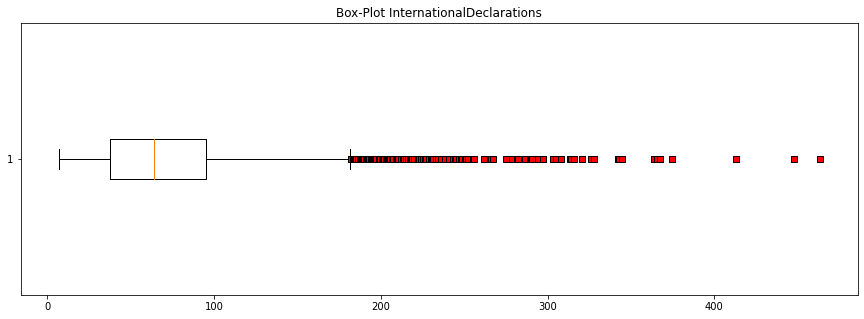

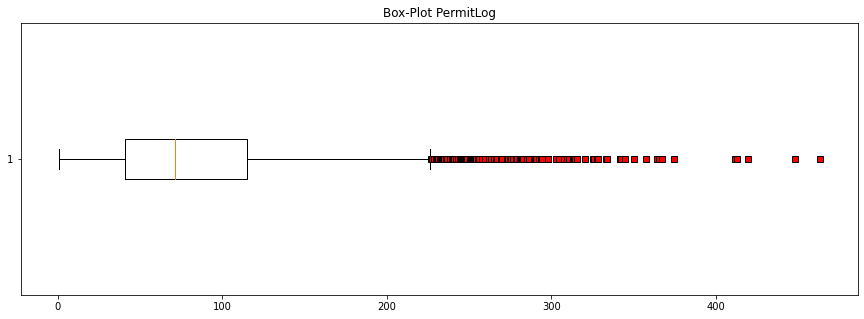

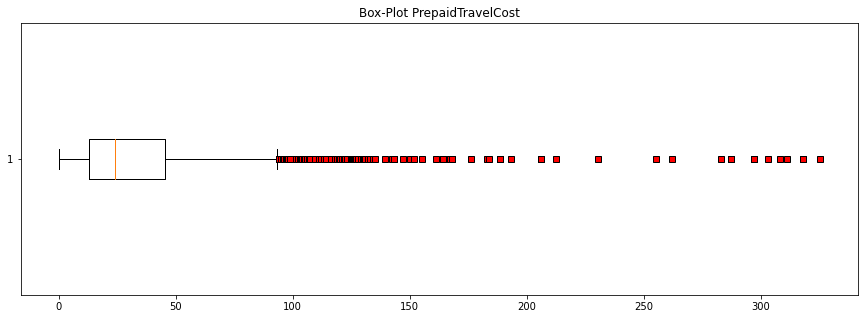

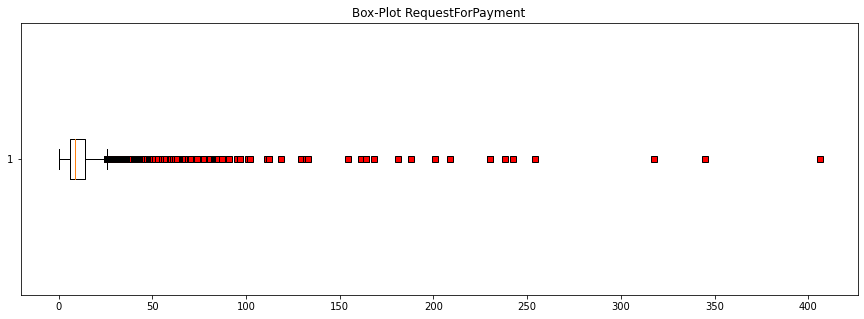

In [ ]:
for k in logs:
  print("Duration statistics for ", k, "log")
  log = logs[k]
  all_case_duration = compute_duration_statistics(log)
  duration_boxplot(all_case_duration, k)

Distribution of the events for  DomesticDeclarations log


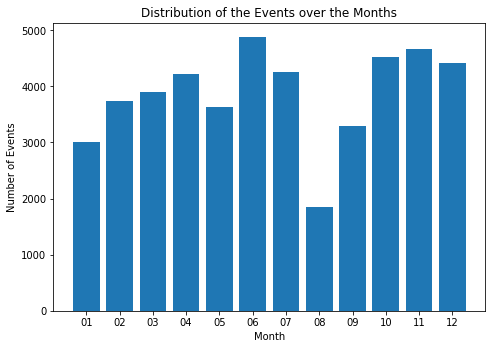

Distribution of the events for  InternationalDeclarations log


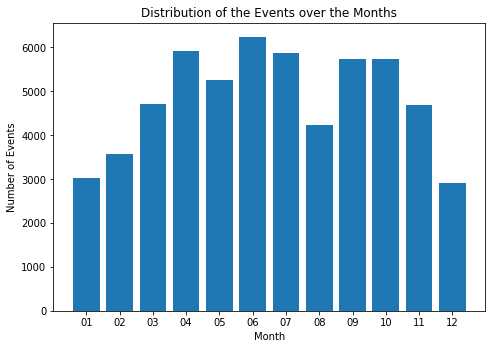

Distribution of the events for  PermitLog log


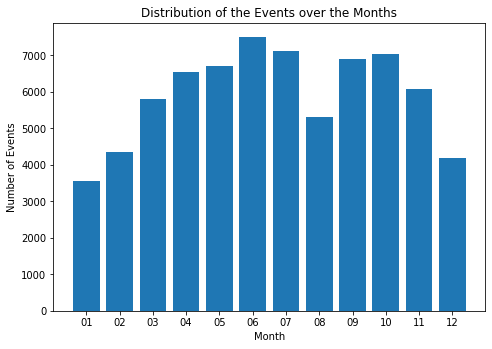

Distribution of the events for  PrepaidTravelCost log


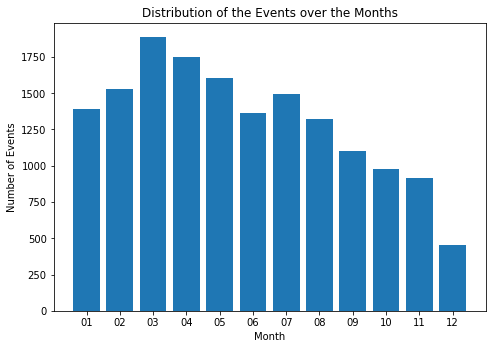

Distribution of the events for  RequestForPayment log


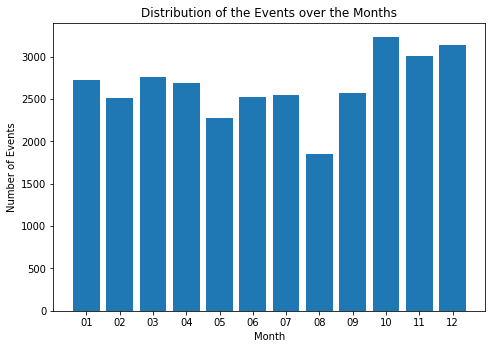

In [ ]:
for k in logs:
  print("Distribution of the events for ", k, "log")
  log = logs[k]
  pm4py.view_events_distribution_graph(log, distr_type="months")

Variant analisys for  DomesticDeclarations log
Number of variants: 63
Variant analisys for  InternationalDeclarations log
Number of variants: 522
Variant analisys for  PermitLog log
Number of variants: 1114
Variant analisys for  PrepaidTravelCost log
Number of variants: 150
Variant analisys for  RequestForPayment log
Number of variants: 59


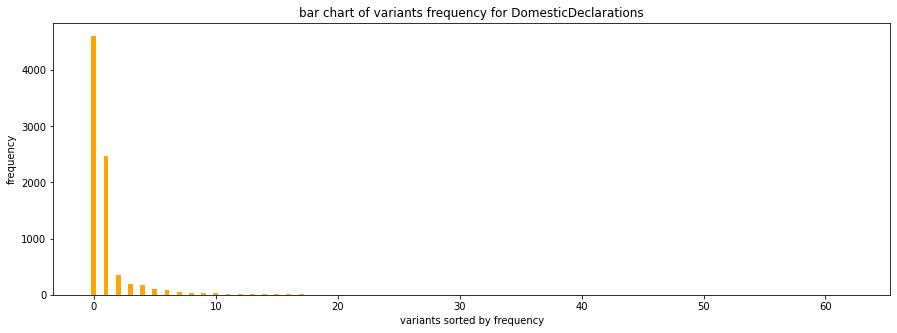

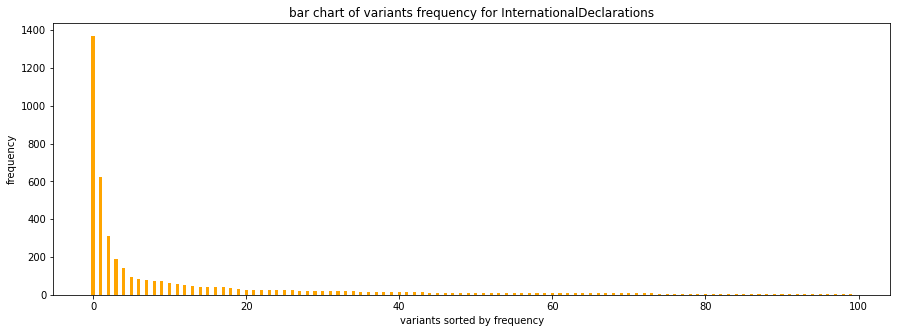

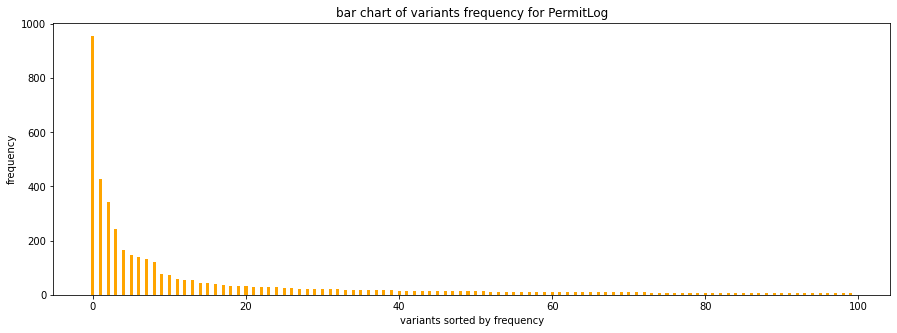

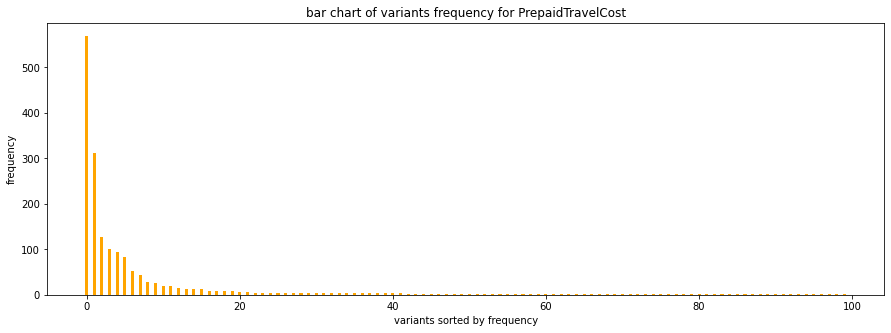

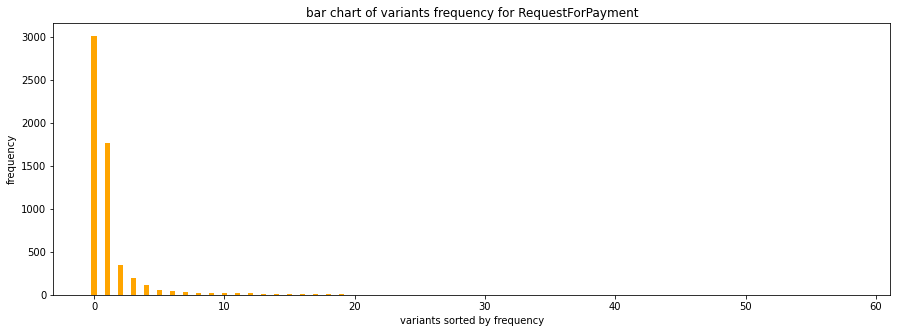

In [ ]:
for k in logs:
  print("Variant analisys for ", k, "log")
  log = logs[k]
  variant_df = variant_analysis(log, k)


**Process Discovery**

In [ ]:
def net_evaluation(event_log, net, im, fm):
  fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
  prec = precision_evaluator.apply(event_log, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
  gen = generalization_evaluator.apply(event_log, net, im, fm)
  simp = simplicity_evaluator.apply(net)
  print('Fitness: ', fitness, 'Precision: ', prec, 'Generalization: ', gen, 'Simplicity: ', simp)
  return [fitness['average_trace_fitness'], prec, gen, simp]

In [ ]:
def discovery_visualize_evaluate(event_log, visualize=True, result_summary=True):
  activities = pm4py.get_event_attribute_values(log, "concept:name")
  n_activities = len(activities)
  print("-----------------------------------------------")
  print("-------------------Dfg visualization-----------")
  if visualize:
    # Create graph from log
    dfg = dfg_discovery.apply(event_log)
    # Visualise
    parameters = {dfg_visualization.Variants.FREQUENCY.value.Parameters.MAX_NO_EDGES_IN_DIAGRAM: n_activities + int(n_activities)
                  }
    gviz = dfg_visualization.apply(dfg, log=event_log, variant=dfg_visualization.Variants.FREQUENCY, 
                                   parameters = parameters)
    dfg_visualization.view(gviz)

  print("-----------------------------------------------")
  print("-------------------Alpha Miner-----------------")
  # Discover a Petri Net using Alpha Miner
  net, im, fm = alpha_miner.apply(event_log)
  if visualize:
  # Visualise 
    gviz = pn_visualizer.apply(net, im, fm, variant=pn_visualizer.Variants.FREQUENCY, log=event_log)
    pn_visualizer.view(gviz)
  # Evaluate
  alpha_res = net_evaluation(event_log, net, im, fm)

  print("-----------------------------------------------")
  print("-------------------Heuristic Miner-------------")
  # Discover a Petri Net using Heuristic Miner
  parameters = {heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.98,
                heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_ACT_COUNT: 5, 
                heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_DFG_OCCURRENCES: 5,
                heuristics_miner.Variants.CLASSIC.value.Parameters.DFG_PRE_CLEANING_NOISE_THRESH: 0.1} 
  net, im, fm = heuristics_miner.apply(event_log, parameters=parameters)
  if visualize:
    # Visualise a Petri Net
    gviz = pn_visualizer.apply(net, im, fm, log=event_log, variant=pn_visualizer.Variants.PERFORMANCE)
    pn_visualizer.view(gviz)
  # Evaluate
  heu_res = net_evaluation(event_log, net, im, fm)

  h_net = net
  h_im = im
  h_fm = fm

  net = heuristics_miner.apply_heu(event_log, parameters=parameters)
  gviz = hn_visualizer.apply(net)
  hn_visualizer.view(gviz)


  print("-----------------------------------------------")
  print("-------------------Inductive Miner-------------")
  # Discover process tree using Inductive Miner Infrequent
  # Produces a more precise model, without fitness guarantees, by eliminating some behavior.
  tree = inductive_miner.apply_tree(event_log)
  from pm4py.visualization.process_tree import visualizer as pt_visualizer
  gviz = pt_visualizer.apply(tree, parameters={pt_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"})
  pt_visualizer.view(gviz)
  # Convert process tree into a Petri Net
  net, im, fm = pt_converter.apply(tree)
  if visualize:
  ## Visualise
    gviz = pn_visualizer.apply(net, im, fm, 
                              variant=pn_visualizer.Variants.FREQUENCY, 
                              log=event_log)
    pn_visualizer.view(gviz)
  # Evaluate
  indu_res = net_evaluation(event_log, net, im, fm)

  #RESULTS
  if result_summary:
    from tabulate import tabulate
    alpha_res.insert(0, 'Alpha')
    heu_res.insert(0, 'Heuristic')
    indu_res.insert(0, 'Inductive')
    print(tabulate([alpha_res, heu_res, indu_res], headers=['Miner', 'Fitness', 'Precision', 'Generalization', 'Simplicity'], tablefmt='orgtbl'))

  return h_net, h_im, h_fm

-----------------------------------------------
-------------------Dfg visualization-----------


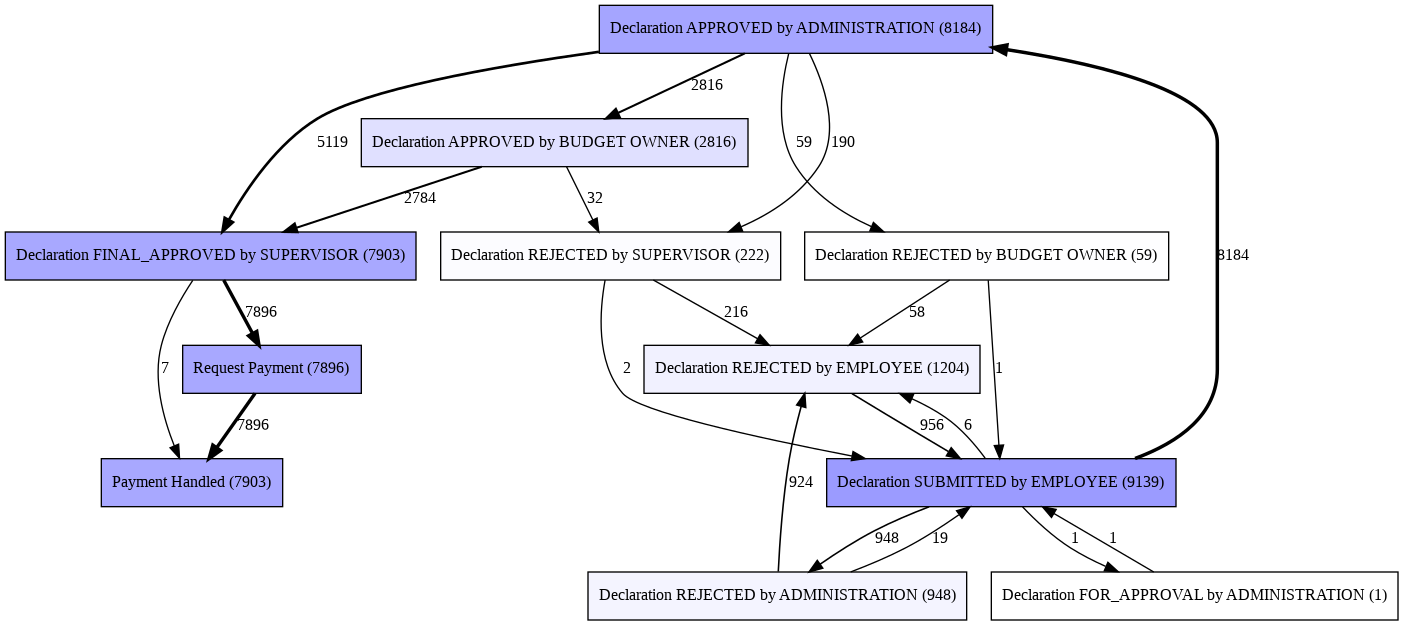

-----------------------------------------------
-------------------Alpha Miner-----------------


replaying log with TBR, completed variants ::   0%|          | 0/63 [00:00<?, ?it/s]

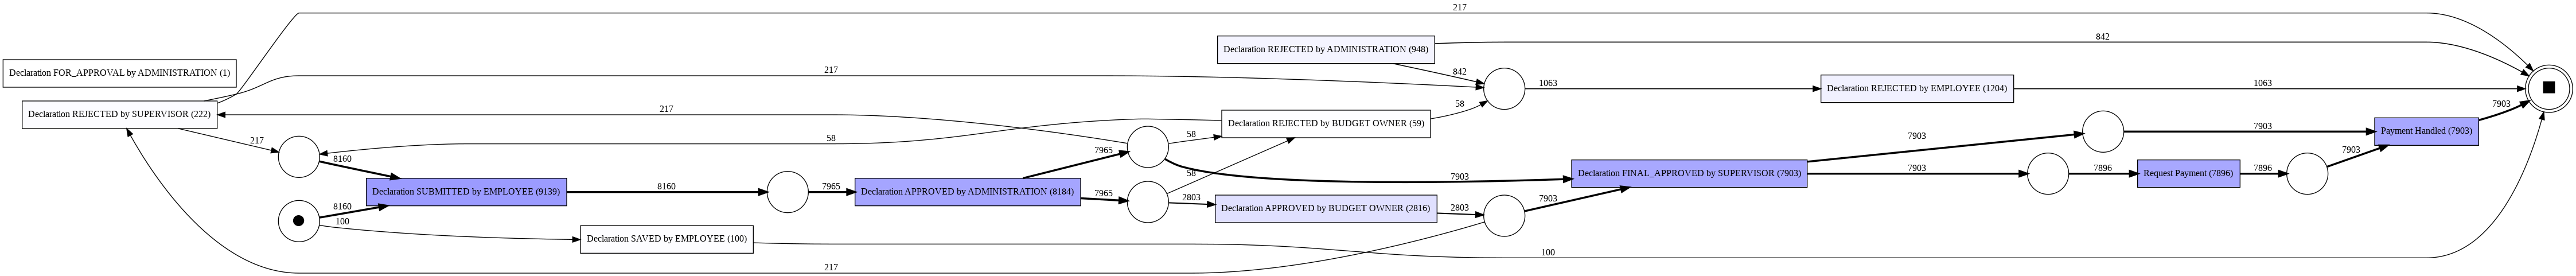

replaying log with TBR, completed variants ::   0%|          | 0/63 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/214 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/63 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 1.2106537530266344, 'average_trace_fitness': 0.8493160481686431, 'log_fitness': 0.8449740867529263, 'percentage_of_fitting_traces': 1.2106537530266344} Precision:  0.33333333333333337 Generalization:  0.8806072832512242 Simplicity:  0.5609756097560976
-----------------------------------------------
-------------------Heuristic Miner-------------


replaying log with TBR, completed variants ::   0%|          | 0/63 [00:00<?, ?it/s]

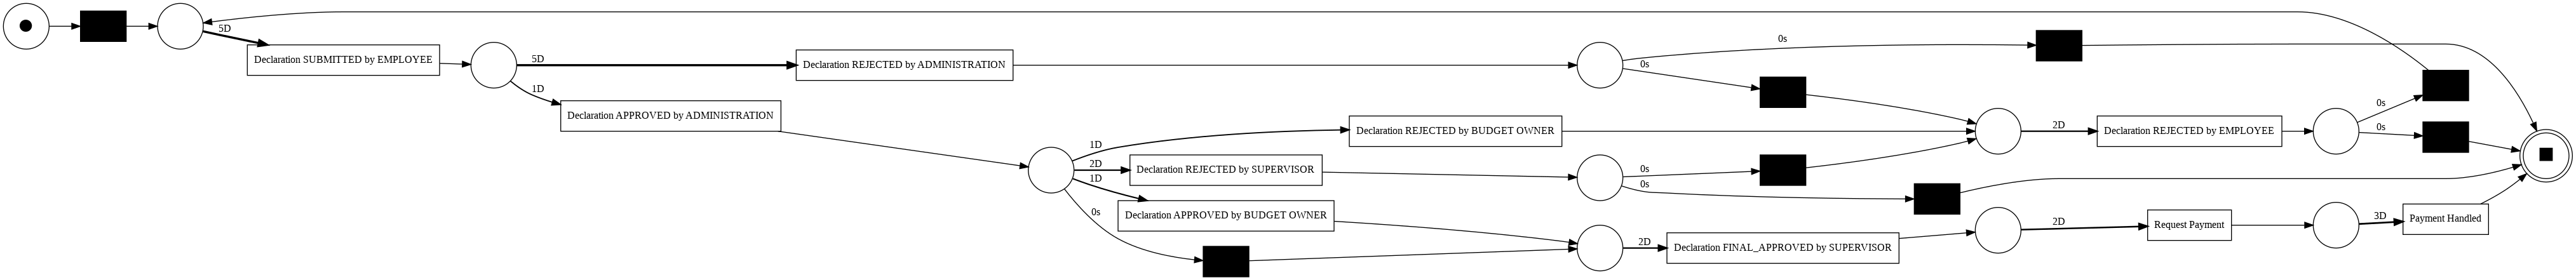

replaying log with TBR, completed variants ::   0%|          | 0/63 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/214 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/63 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 98.12348668280872, 'average_trace_fitness': 0.9873032614295727, 'log_fitness': 0.997691057837576, 'percentage_of_fitting_traces': 98.12348668280872} Precision:  0.9972368404526558 Generalization:  0.9228722218326839 Simplicity:  0.7142857142857143


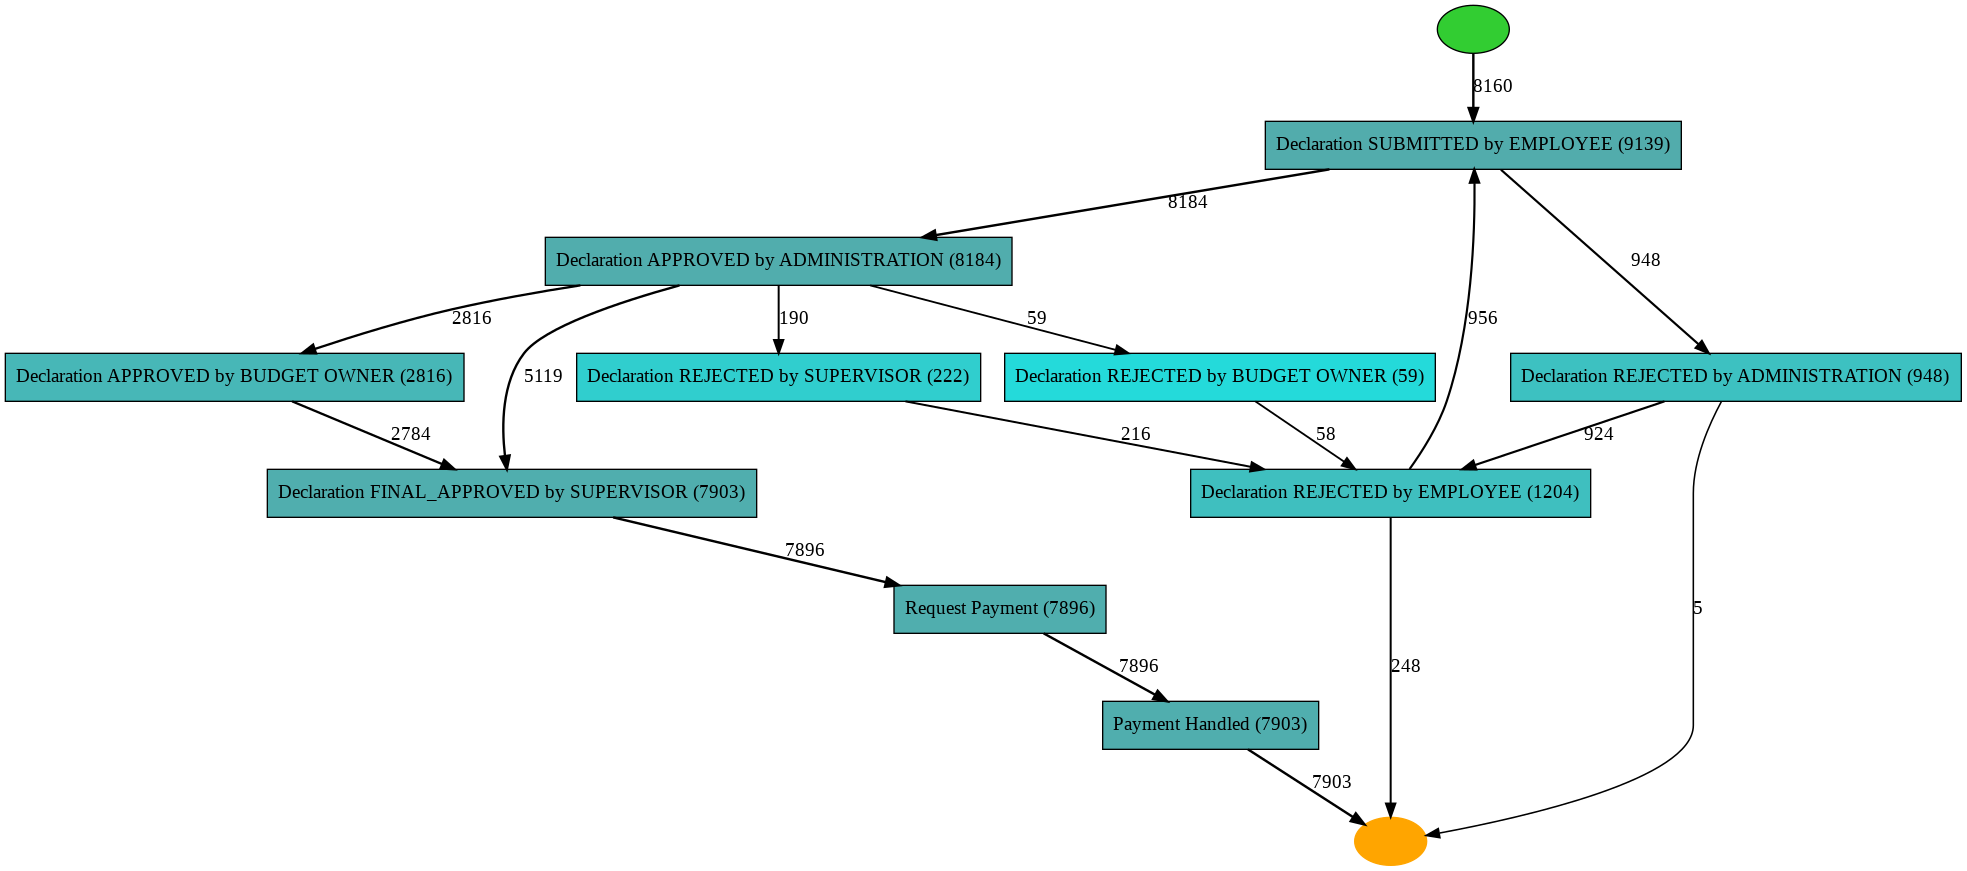

-----------------------------------------------
-------------------Inductive Miner-------------


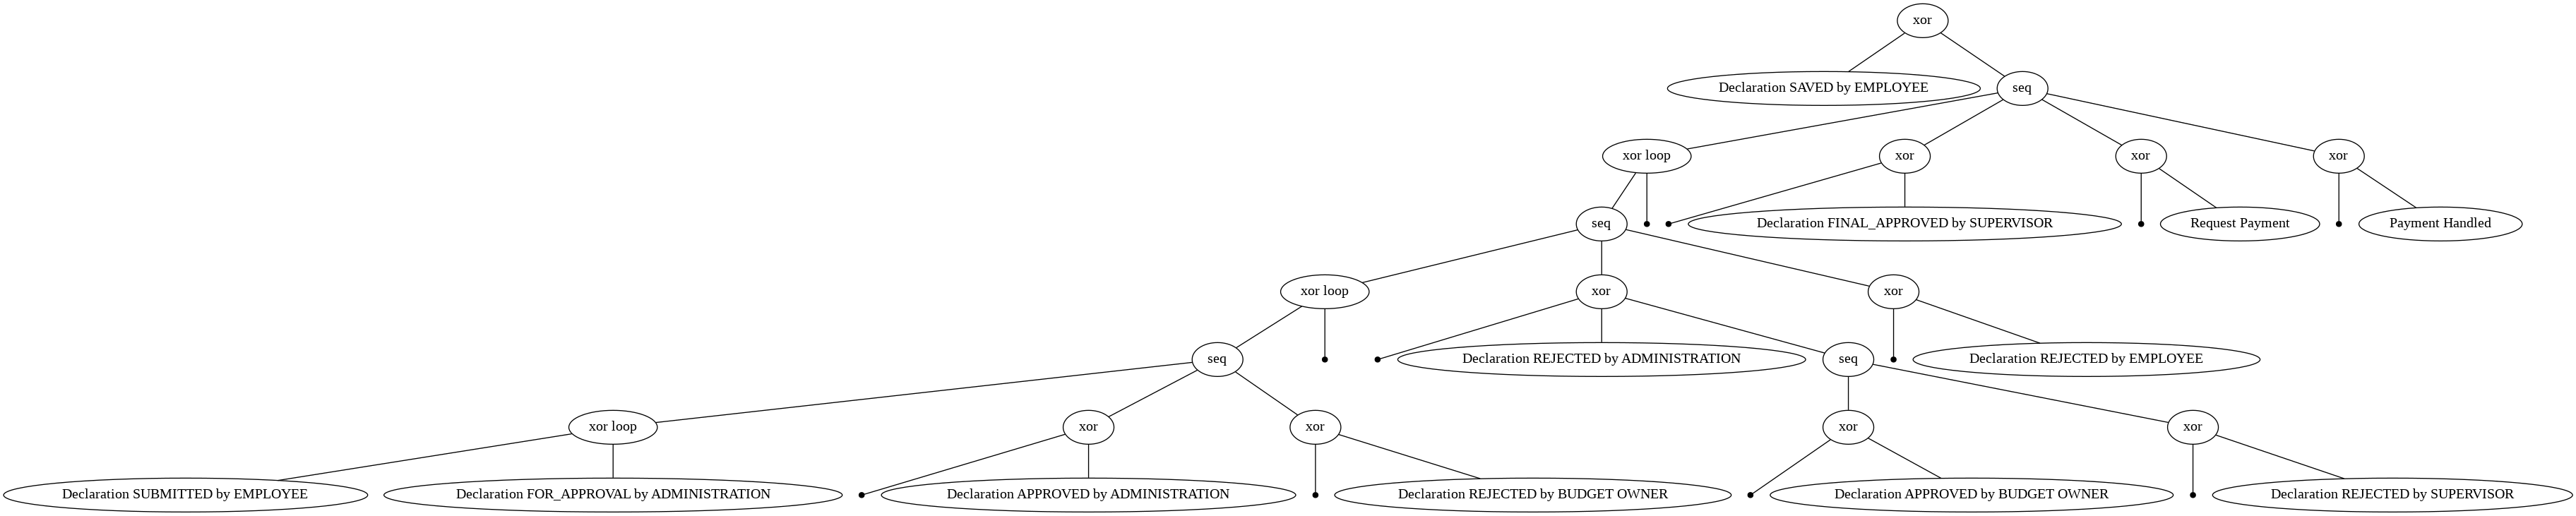

replaying log with TBR, completed variants ::   0%|          | 0/63 [00:00<?, ?it/s]

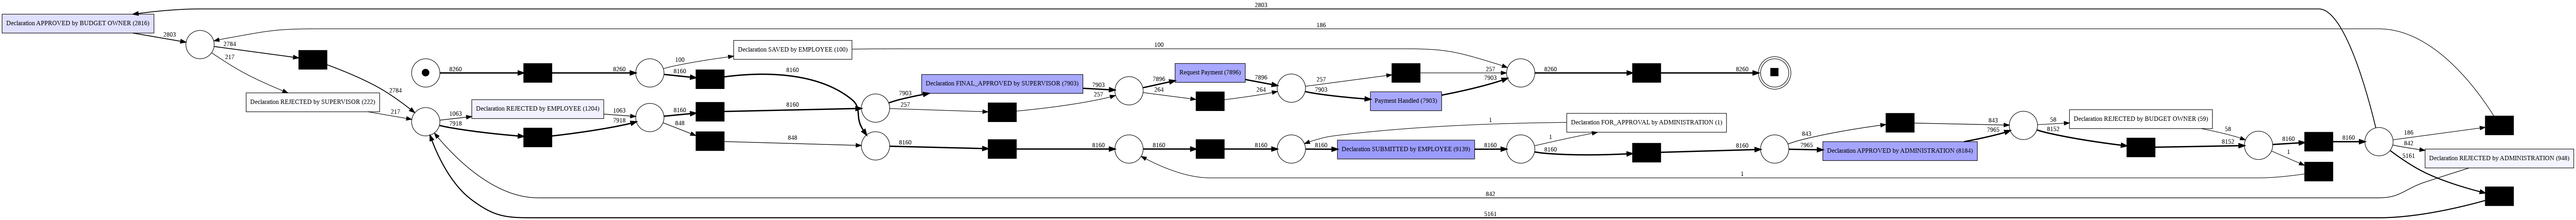

replaying log with TBR, completed variants ::   0%|          | 0/63 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/214 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/63 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0} Precision:  0.4096891116588306 Generalization:  0.9065648951907164 Simplicity:  0.6533333333333333
| Miner     |   Fitness |   Precision |   Generalization |   Simplicity |
|-----------+-----------+-------------+------------------+--------------|
| Alpha     |  0.849316 |    0.333333 |         0.880607 |     0.560976 |
| Heuristic |  0.987303 |    0.997237 |         0.922872 |     0.714286 |
| Inductive |  1        |    0.409689 |         0.906565 |     0.653333 |


In [ ]:
dom_net, dom_im, dom_fm = discovery_visualize_evaluate(domesticDeclarations, visualize = True)

-----------------------------------------------
-------------------Dfg visualization-----------


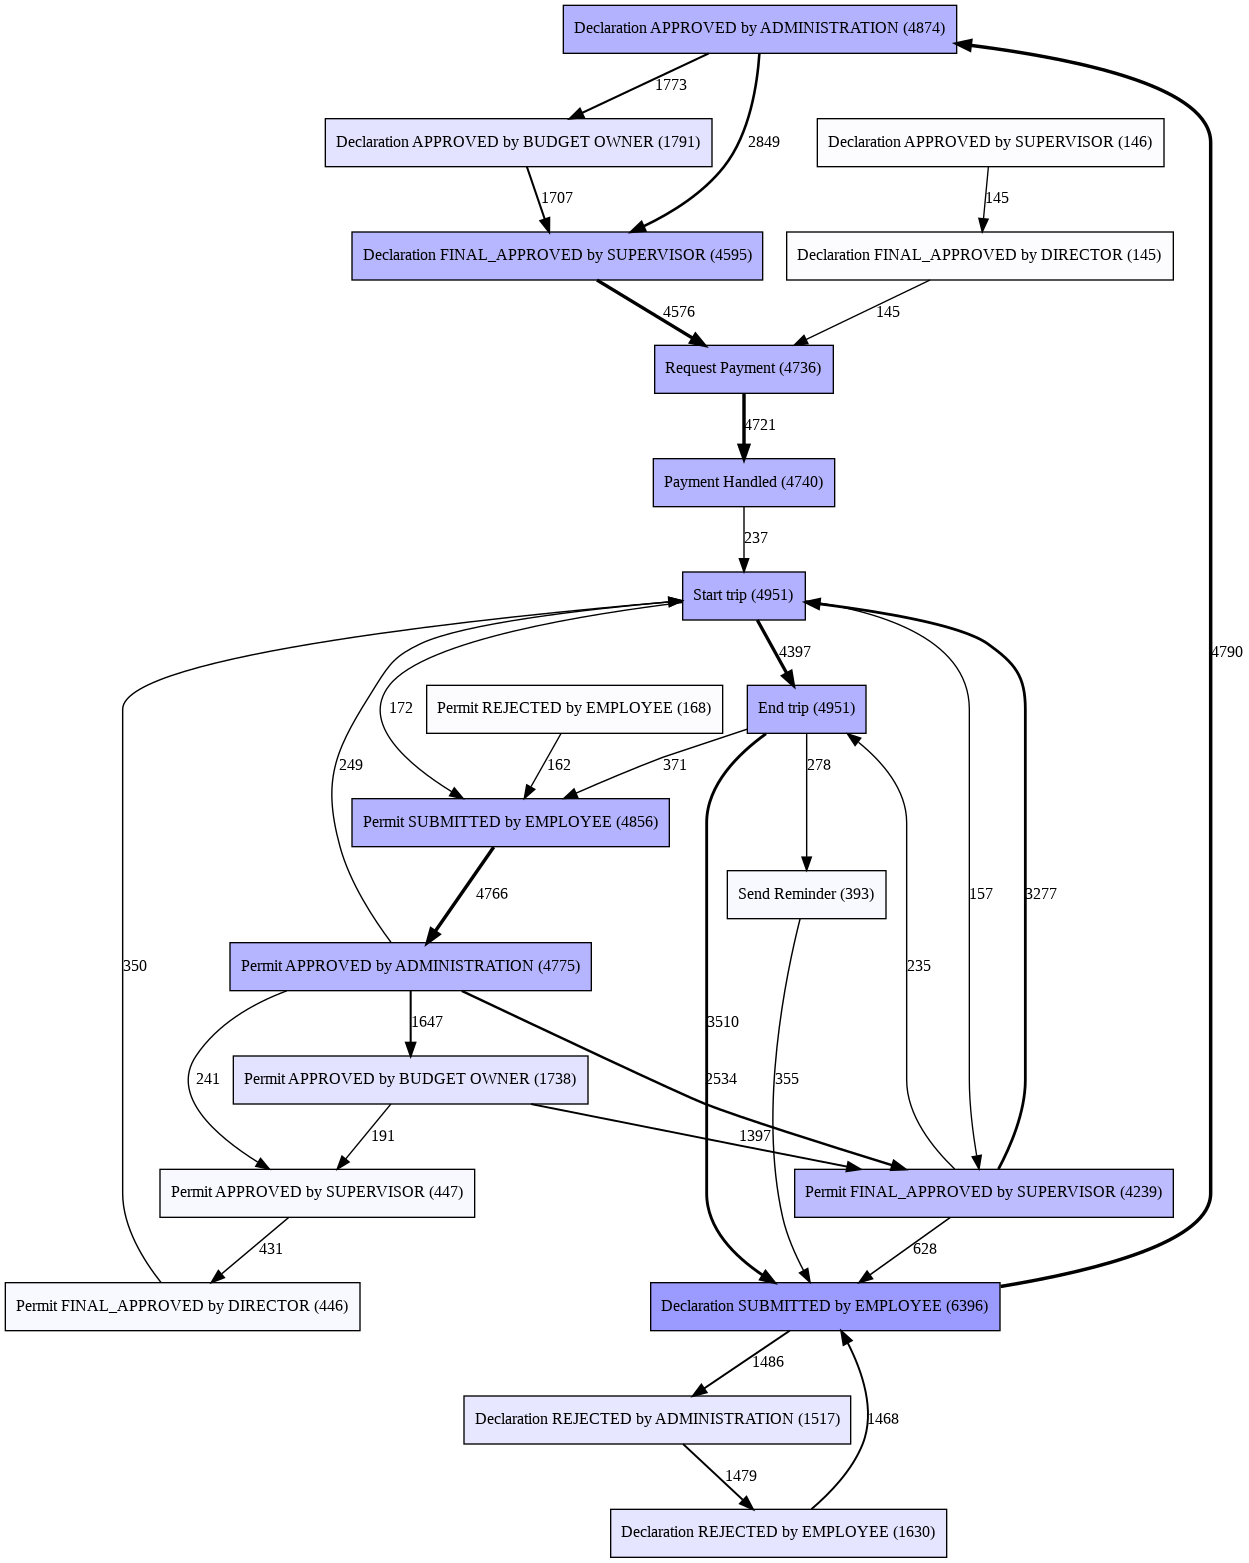

-----------------------------------------------
-------------------Alpha Miner-----------------


replaying log with TBR, completed variants ::   0%|          | 0/522 [00:00<?, ?it/s]

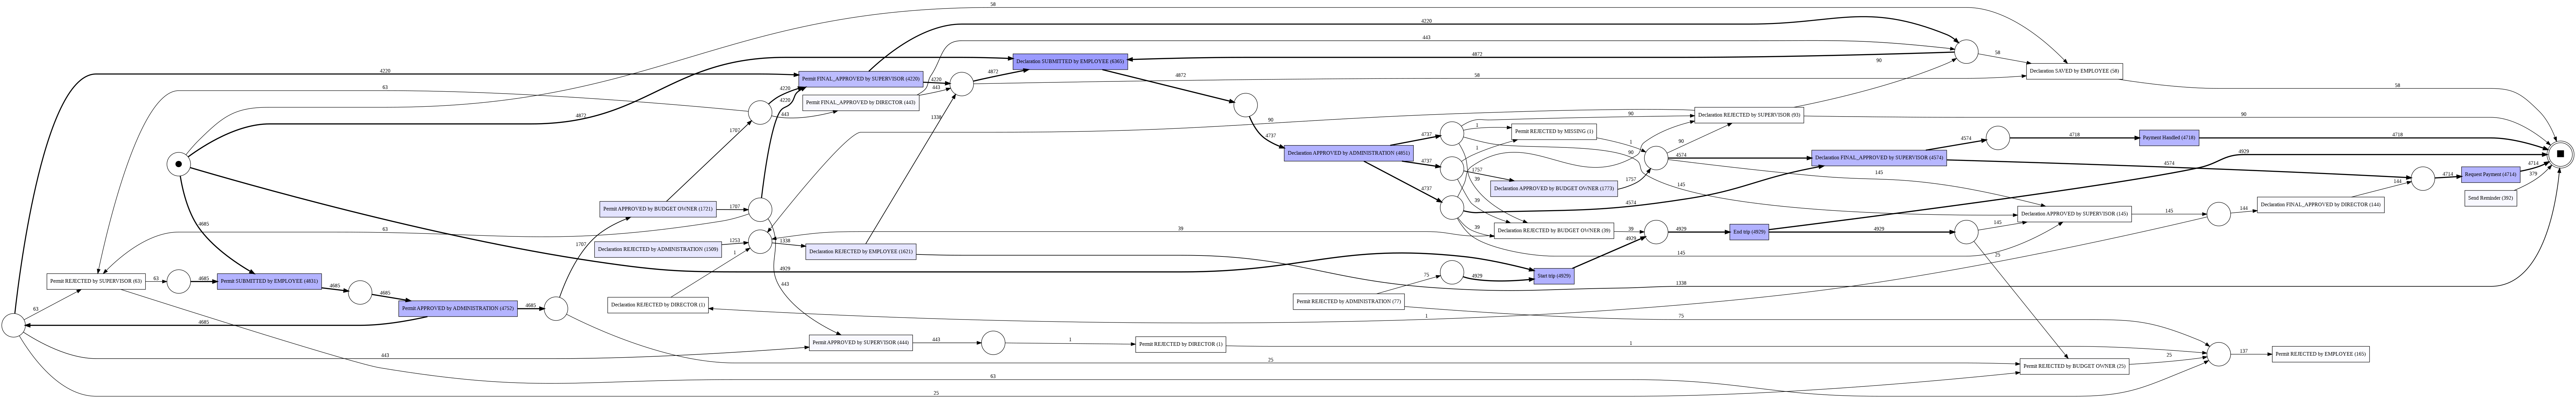

replaying log with TBR, completed variants ::   0%|          | 0/522 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2852 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/522 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.6762500958077613, 'log_fitness': 0.6807790588305668, 'percentage_of_fitting_traces': 0.0} Precision:  0.0 Generalization:  0.846257201709615 Simplicity:  0.41732283464566927
-----------------------------------------------
-------------------Heuristic Miner-------------


replaying log with TBR, completed variants ::   0%|          | 0/522 [00:00<?, ?it/s]

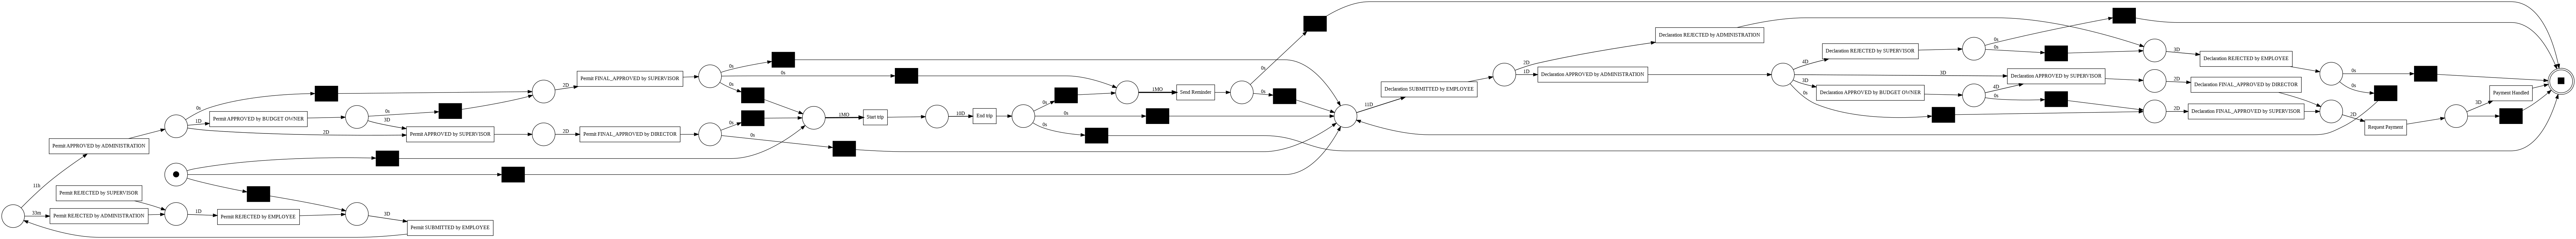

replaying log with TBR, completed variants ::   0%|          | 0/522 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2852 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/522 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 62.53282165219148, 'average_trace_fitness': 0.9771845897256198, 'log_fitness': 0.9787859433198698, 'percentage_of_fitting_traces': 62.53282165219148} Precision:  0.656575338195873 Generalization:  0.8906449006534387 Simplicity:  0.6545454545454545


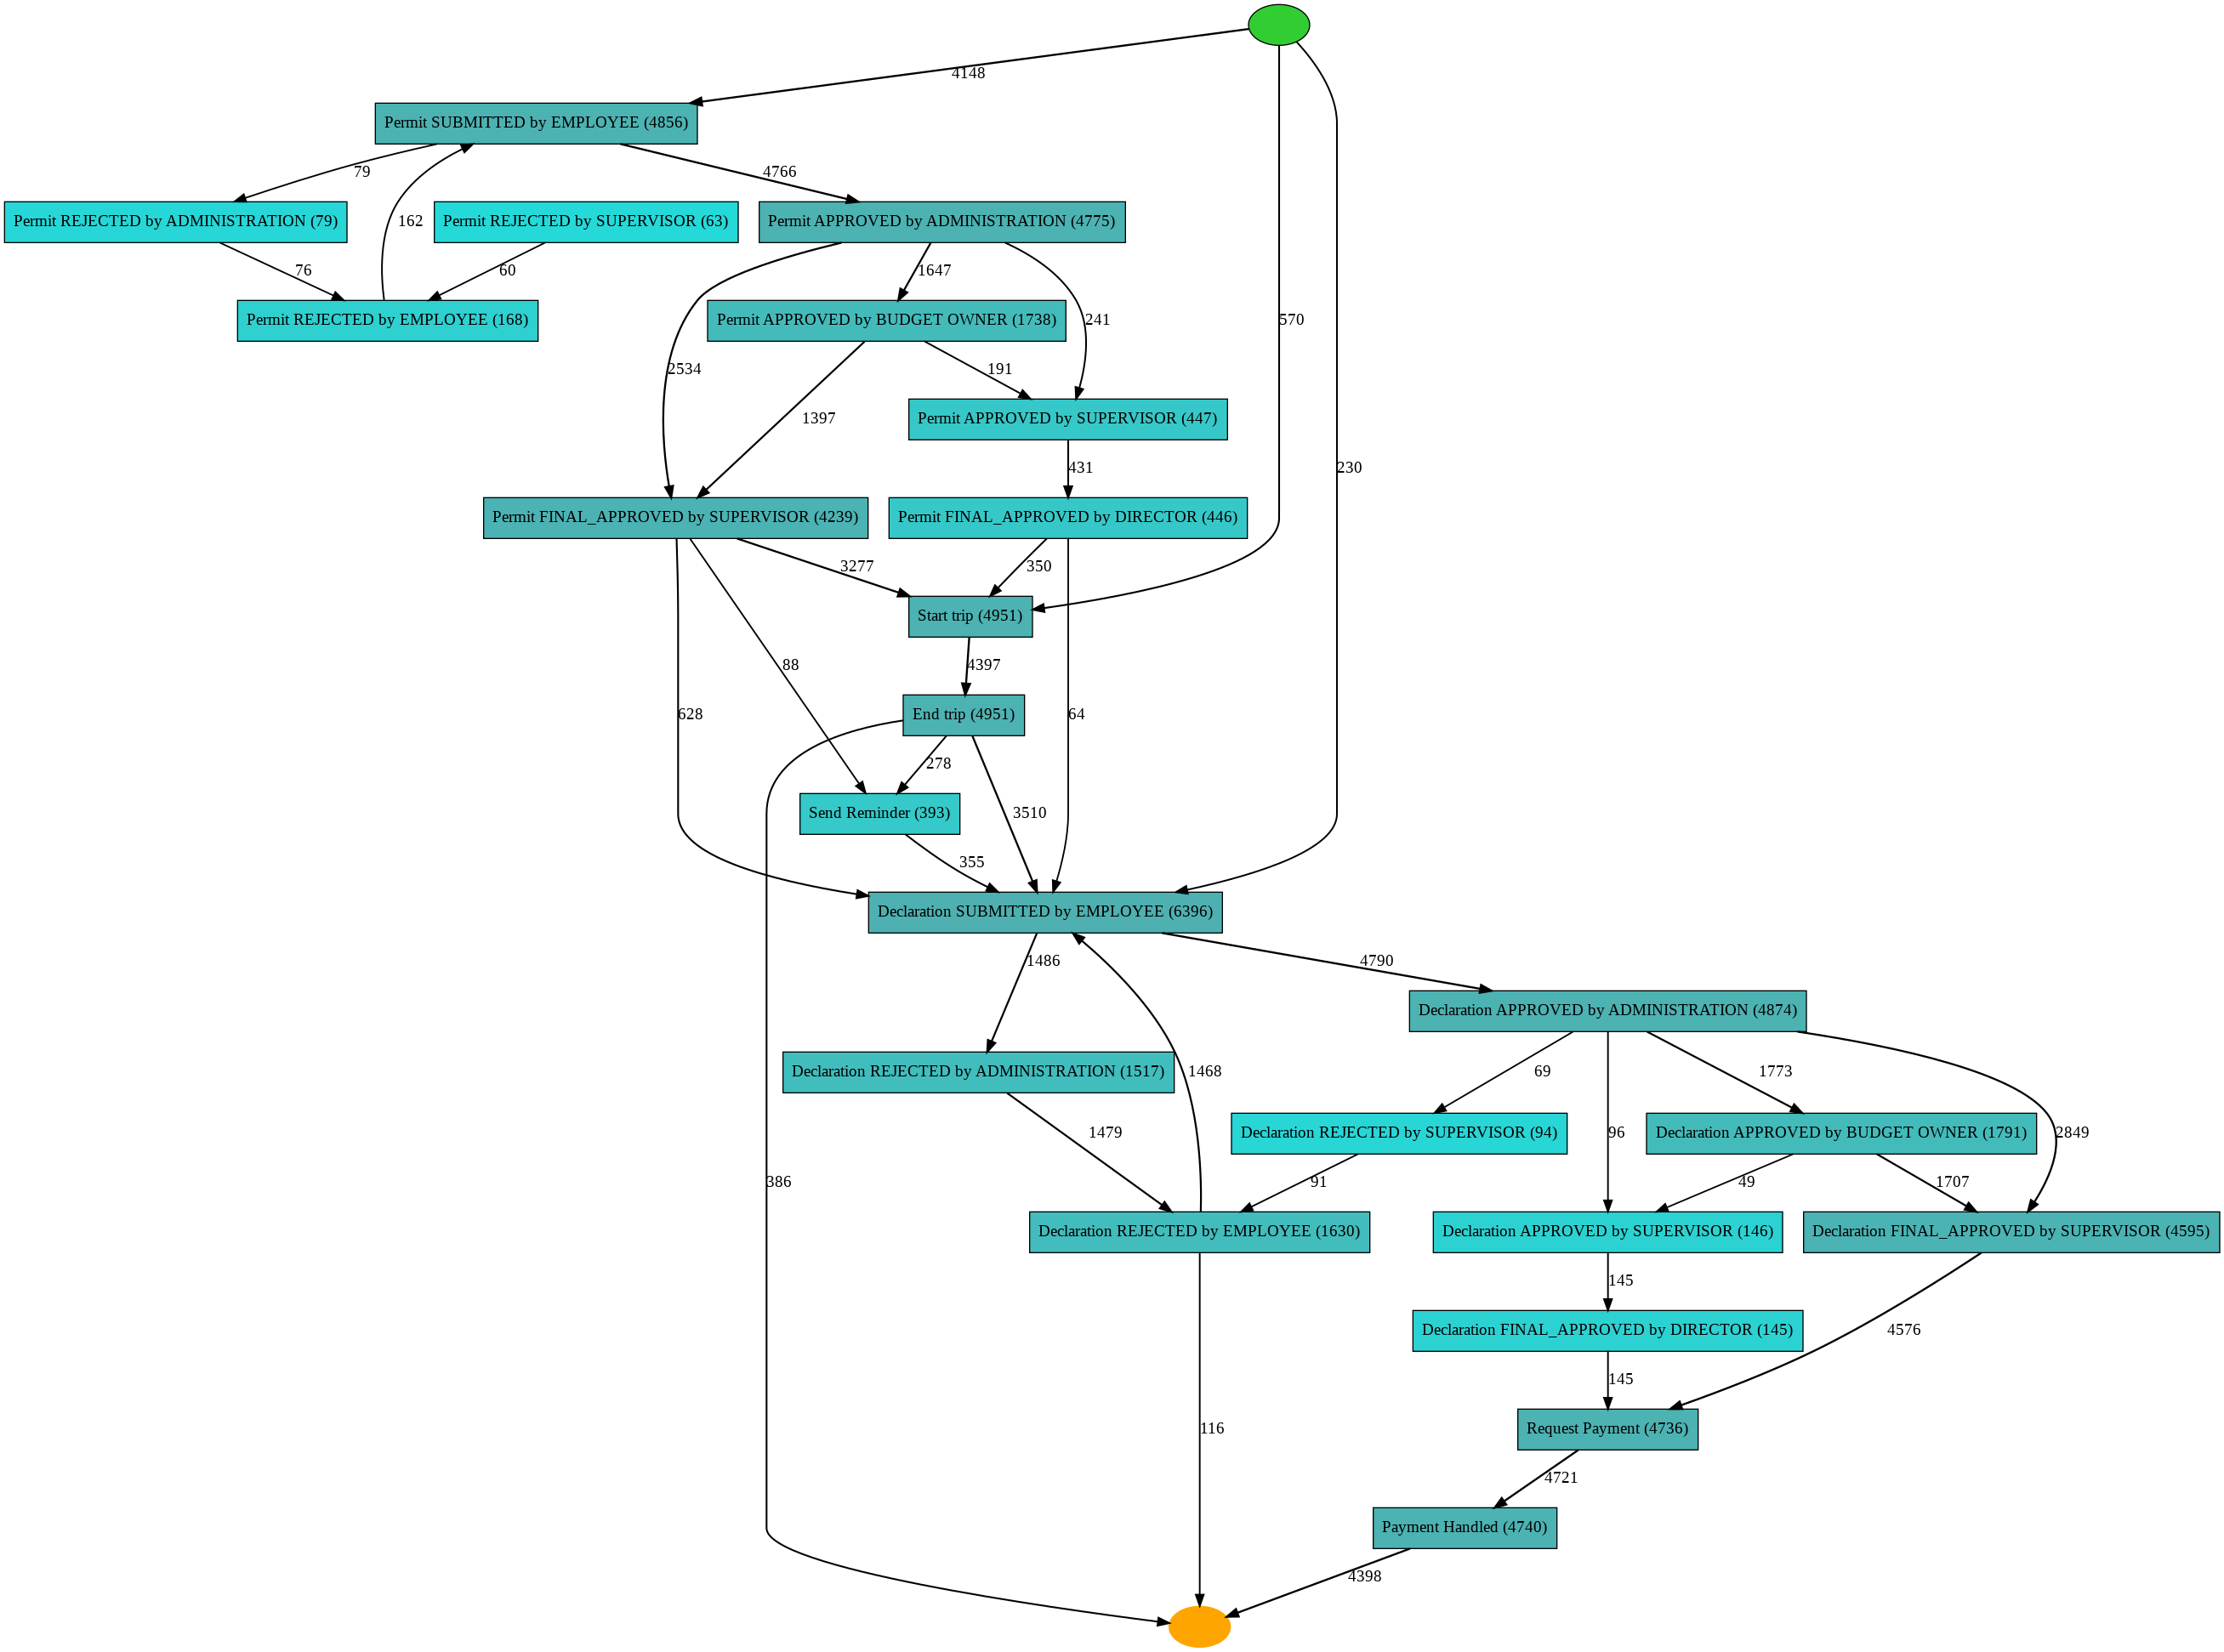

-----------------------------------------------
-------------------Inductive Miner-------------


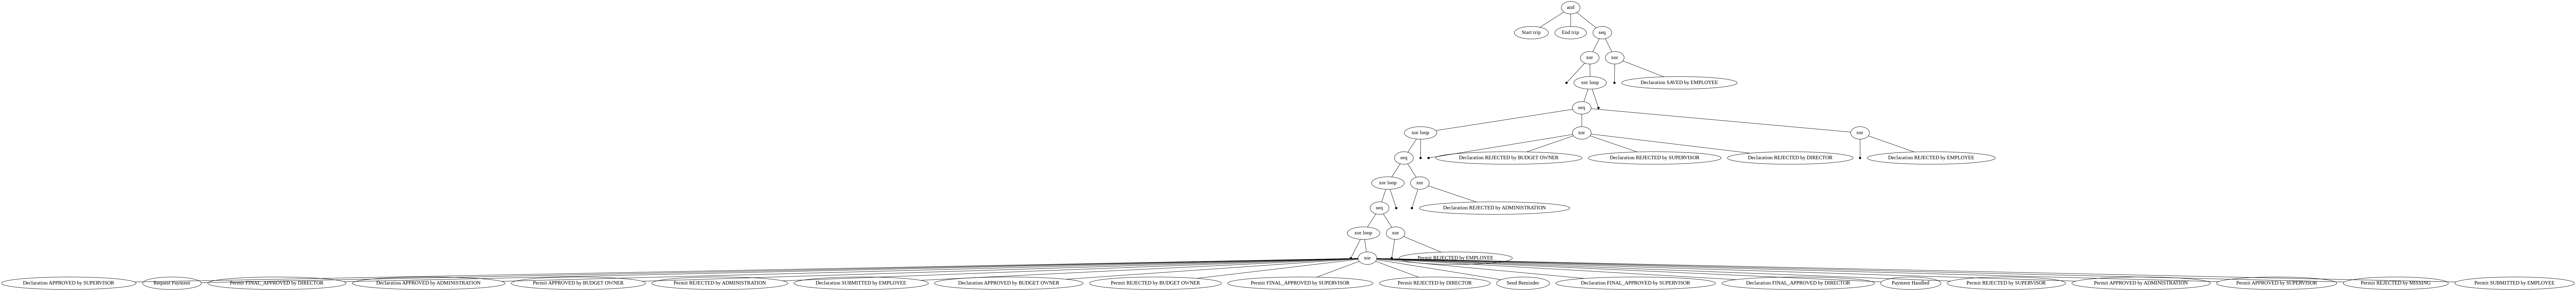

replaying log with TBR, completed variants ::   0%|          | 0/522 [00:00<?, ?it/s]

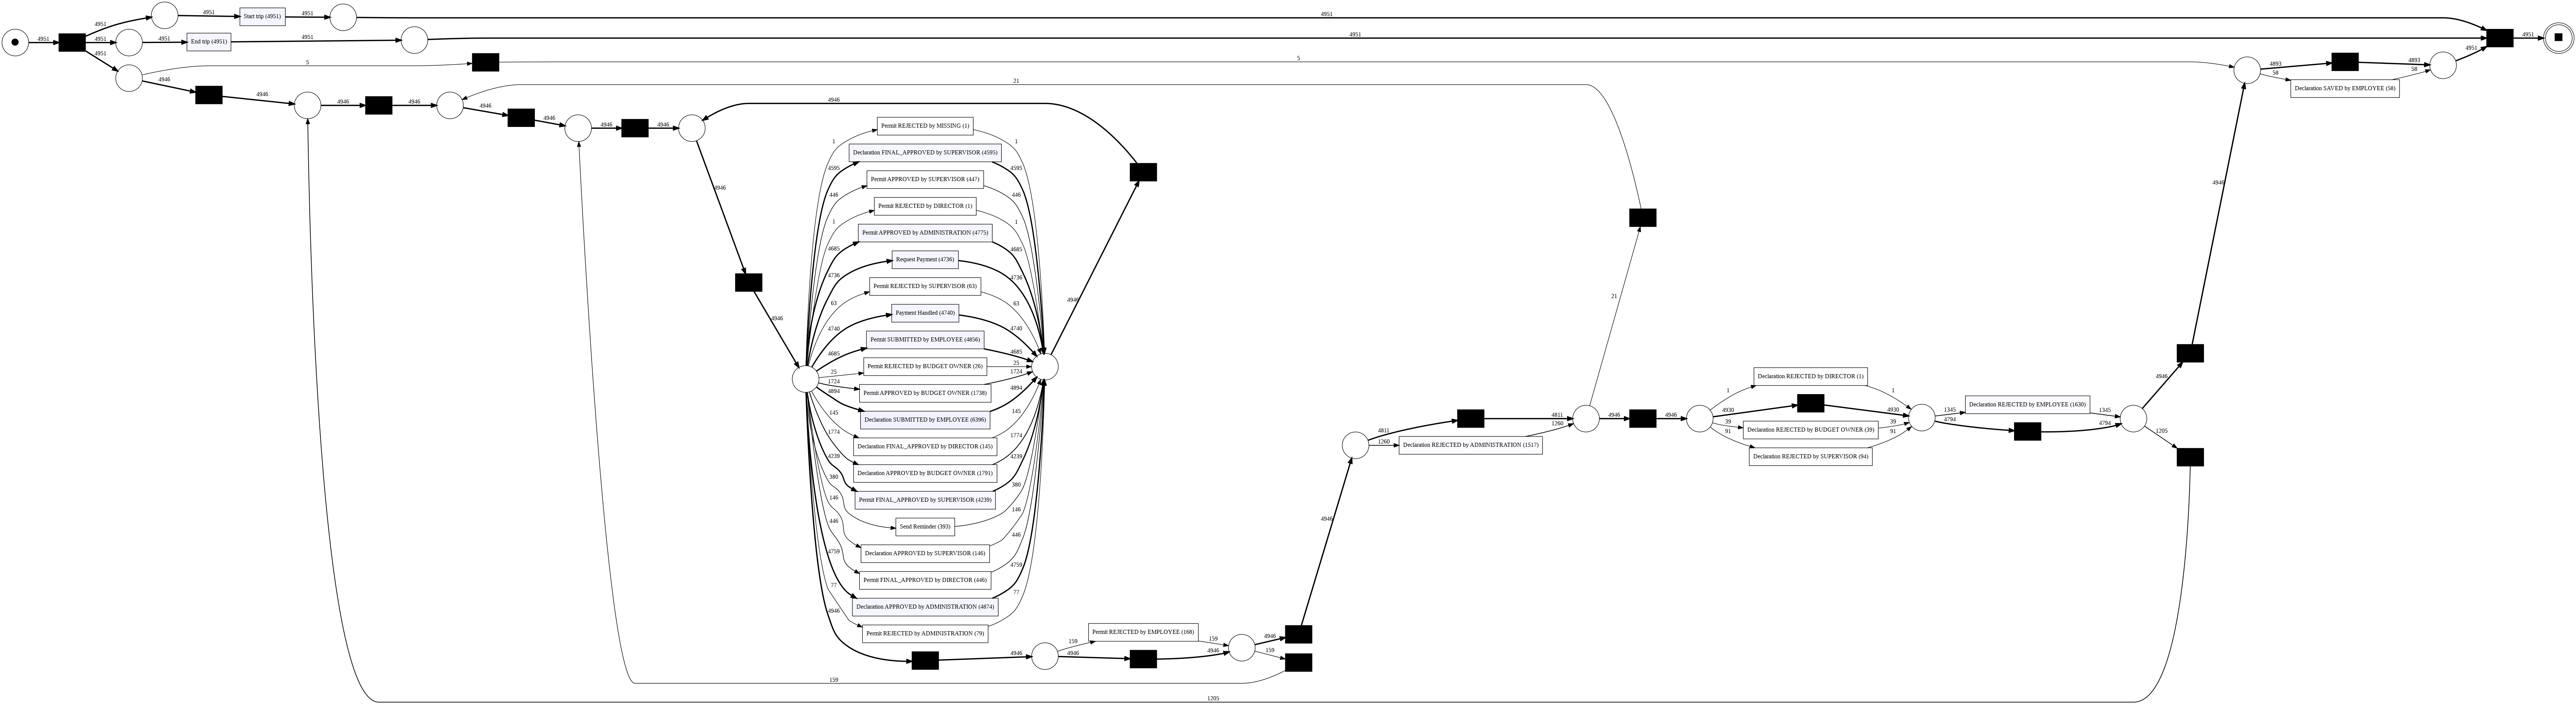

replaying log with TBR, completed variants ::   0%|          | 0/522 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2852 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/522 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0} Precision:  0.09997653759447034 Generalization:  0.8914812790824339 Simplicity:  0.5294117647058824
| Miner     |   Fitness |   Precision |   Generalization |   Simplicity |
|-----------+-----------+-------------+------------------+--------------|
| Alpha     |  0.67625  |   0         |         0.846257 |     0.417323 |
| Heuristic |  0.977185 |   0.656575  |         0.890645 |     0.654545 |
| Inductive |  1        |   0.0999765 |         0.891481 |     0.529412 |


In [ ]:
int_net, int_im, int_fm = discovery_visualize_evaluate(internationalDeclarations, visualize = True)

**Conformance Checking**


Using the net discovered by the heuristic miner

In [ ]:
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments

def conformance_checking_replay(event_log, net, im, fm):
  replayed_traces = token_replay.apply(event_log, net, im, fm)
  print("REPLAY")
  print("Number of traces", len(replayed_traces))

  anomalous_traces = []
  i = 0
  while i < len(replayed_traces):
    if replayed_traces[i]["trace_fitness"] < 1:
      anomalous_traces.append(event_log[i].attributes["concept:name"])
    i += 1
  # print the list as a string
  print(', '.join(map(str, anomalous_traces)))
  print("Number of anomalous traces ", len(anomalous_traces))

  print("Percentage of anomalous traces", (len(anomalous_traces)/len(replayed_traces))*100 , '%')

  anomalous_traces_type = {}
  anomalous_traces_type_keys = []


  i = 0
  while i < len(replayed_traces):
    if replayed_traces[i]["transitions_with_problems"]: # Empty lists are considered False in Python
      key = i
      anomalous_traces_type[key] = replayed_traces[i]["transitions_with_problems"][0]
      anomalous_traces_type_keys.append(key)
      #print(replayed_traces[i]["transitions_with_problems"][0])
    i += 1
  print(anomalous_traces_type)

  # store the names (the keys of the new dict) as a set (keeps elements unique)
  att = set(anomalous_traces_type.values())

  # use a list comprehension, iterating through keys and checking the values match each n
  anomalous_traces_type_groups = {}
  for n in att:
      anomalous_traces_type_groups[n] = [k for k in anomalous_traces_type.keys() if anomalous_traces_type[k] == n]
  print(anomalous_traces_type_groups)


def conformance_checking_alignment(event_log, net, im, fm):
  # Alignment-based replay aims to find one of the best alignment between the trace and the model.
  aligned_traces = alignments.apply_log(event_log, net, im, fm)

  print("ALIGNMENTS")
  print("Number of traces", len(aligned_traces))

  anomalous_traces = []
  regular_traces = []
  i = 0
  while i < len(aligned_traces):
    if aligned_traces[i]["fitness"] != 1:
      #anomalous_traces.append(event_log[i].attributes["concept:name"])
      anomalous_traces.append(aligned_traces[i]['alignment'])
    else:
      regular_traces.append(aligned_traces[i]['alignment'])
    i += 1
  # print the list as a string
  #print(', '.join(map(str, anomalous_traces)))
  print(anomalous_traces)
  print("Number of anomalous traces ", len(anomalous_traces))

  print("Percentage of anomalous traces", (len(anomalous_traces)/len(aligned_traces))*100 , '%')

  # Generate a Dataframe of the regular traces
  regular_traces_df = pd.DataFrame(regular_traces)


  # Generate the Consensus Sequence: The consensus sequence captures the major activity in each column and can be considered as a back-bone sequence for the process.
  # For each column print the mode value, its absolute occurence, its relative occurence 
  alignments_mode_count = pd.DataFrame({'Columns': regular_traces_df.columns,
                      'Mode':[regular_traces_df[x].mode()[0] for x in regular_traces_df],
                    'Mode freq.':[regular_traces_df[x].isin(regular_traces_df[x].mode()).sum() for x in regular_traces_df],
                    'Mode freq. %':[(regular_traces_df[x].isin(regular_traces_df[x].mode()).sum())/(len(aligned_traces))*100 for x in regular_traces_df]
                    })
  print(alignments_mode_count)

  # Print the consenus sequence only 
  consensus_sequence = alignments_mode_count['Mode'].tolist()
  print(consensus_sequence)

  # Visualize the share of each activity in the consensus sequence
  fig, axes = plt.subplots(figsize=(7,5), dpi=100)
  plt.bar(alignments_mode_count['Columns'], height=alignments_mode_count['Mode freq. %'])
  plt.title('Share of each activity in the consensus sequence')


In [ ]:
conformance_checking_replay(domesticDeclarations, dom_net, dom_im, dom_fm)

replaying log with TBR, completed variants ::   0%|          | 0/63 [00:00<?, ?it/s]

REPLAY
Number of traces 8260
declaration 99093, declaration 104930, declaration 102047, declaration 108681, declaration 97095, declaration 99493, declaration 104830, declaration 109624, declaration 105242, declaration 105059, declaration 100880, declaration 109050, declaration 99961, declaration 101610, declaration 96649, declaration 101937, declaration 105561, declaration 101987, declaration 105730, declaration 110248, declaration 102261, declaration 97401, declaration 110524, declaration 110600, declaration 107348, declaration 107732, declaration 106270, declaration 96998, declaration 107991, declaration 108034, declaration 106342, declaration 101426, declaration 108835, declaration 107287, declaration 109435, declaration 109437, declaration 109518, declaration 103462, declaration 98055, declaration 104366, declaration 108171, declaration 108190, declaration 103681, declaration 108210, declaration 103874, declaration 108479, declaration 98570, declaration 104701, declaration 99019, d

aligning log, completed variants ::   0%|          | 0/63 [00:00<?, ?it/s]

ALIGNMENTS
Number of traces 8260
[[('Declaration SAVED by EMPLOYEE', '>>'), ('>>', None), ('>>', 'Declaration SUBMITTED by EMPLOYEE'), ('>>', 'Declaration REJECTED by ADMINISTRATION'), ('>>', None)], [('Declaration SAVED by EMPLOYEE', '>>'), ('>>', None), ('>>', 'Declaration SUBMITTED by EMPLOYEE'), ('>>', 'Declaration REJECTED by ADMINISTRATION'), ('>>', None)], [('Declaration SAVED by EMPLOYEE', '>>'), ('>>', None), ('>>', 'Declaration SUBMITTED by EMPLOYEE'), ('>>', 'Declaration REJECTED by ADMINISTRATION'), ('>>', None)], [('Declaration SAVED by EMPLOYEE', '>>'), ('>>', None), ('>>', 'Declaration SUBMITTED by EMPLOYEE'), ('>>', 'Declaration REJECTED by ADMINISTRATION'), ('>>', None)], [('Declaration SAVED by EMPLOYEE', '>>'), ('>>', None), ('>>', 'Declaration SUBMITTED by EMPLOYEE'), ('>>', 'Declaration REJECTED by ADMINISTRATION'), ('>>', None)], [('Declaration SAVED by EMPLOYEE', '>>'), ('>>', None), ('>>', 'Declaration SUBMITTED by EMPLOYEE'), ('>>', 'Declaration REJECTED by ADM

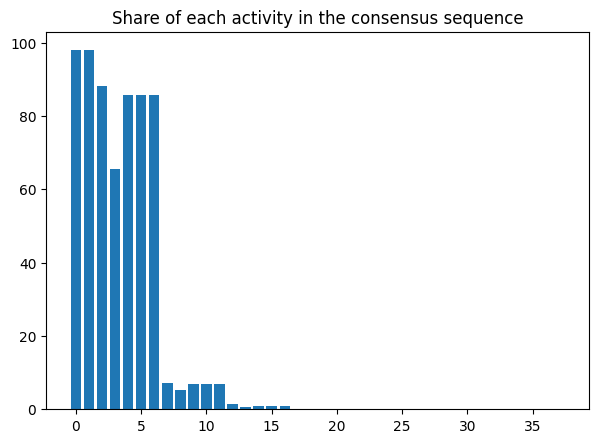

In [ ]:
conformance_checking_alignment(domesticDeclarations, dom_net, dom_im, dom_fm)

In [ ]:
replayed_traces = pm4py.conformance_diagnostics_token_based_replay(domesticDeclarations, dom_net, dom_im, dom_fm)
replayed_traces

replaying log with TBR, completed variants ::   0%|          | 0/63 [00:00<?, ?it/s]

[{'activated_transitions': [(hid_2, None),
   (Declaration SUBMITTED by EMPLOYEE, 'Declaration SUBMITTED by EMPLOYEE'),
   (Declaration APPROVED by ADMINISTRATION, 'Declaration APPROVED by ADMINISTRATION'),
   (hid_11, None),
   (Declaration FINAL_APPROVED by SUPERVISOR, 'Declaration FINAL_APPROVED by SUPERVISOR'),
   (Request Payment, 'Request Payment'),
   (Payment Handled, 'Payment Handled')],
  'consumed_tokens': 8,
  'enabled_transitions_in_marking': set(),
  'missing_tokens': 0,
  'produced_tokens': 8,
  'reached_marking': Marking({sink0: 1}),
  'remaining_tokens': 0,
  'trace_fitness': 1.0,
  'trace_is_fit': True,
  'transitions_with_problems': []},
 {'activated_transitions': [],
  'consumed_tokens': 1,
  'enabled_transitions_in_marking': {(Declaration SUBMITTED by EMPLOYEE, 'Declaration SUBMITTED by EMPLOYEE')},
  'missing_tokens': 1,
  'produced_tokens': 1,
  'reached_marking': Marking({source0: 1}),
  'remaining_tokens': 1,
  'trace_fitness': 0.0,
  'trace_is_fit': False,
  '